In [11]:
import json
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import numpy as np
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
import random
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets
from sklearn.inspection import DecisionBoundaryDisplay

In [12]:
con = sqlite3.connect(r"../laliga.sqlite")
# Change date format (2029 -> 1929)
df = pd.read_sql_query("SELECT * FROM Matches", con)

# Data formatting:
# We split the "date" column into the corresponding columns, and specify the correct formatting.
# This way we avoid the year 29 or higher to be mistaken by 2029 (error with to_datetime function).
df[["month", "day", "year"]] = df["date"].str.split("/", 2, expand = True)
df["year"] = df["year"].apply(lambda x: f"19{x}" if int(x) >= 23 else f"20{x}")
df['date'] = pd.to_datetime(df[['day', 'month', 'year']]).dt.strftime('%d/%m/%Y') 

# We also change the formatting of the time to be in 24h format
df['time'] = df['time'].apply(lambda x: datetime.strftime(datetime.strptime(x, "%I:%M %p"), "%H:%M") if type(x) == str else x)

df[["home_goals", "away_goals"]] = df["score"].str.split(":", expand=True).astype(float)
df2=df.dropna(subset = "score")
df2["goal diff"] = (df2["home_goals"]  - df2["away_goals"])
df2["results"] = np.where(df2["goal diff"] > 0, "1", np.where(df2["goal diff"] < 0, "2", "X"))
df2['home_win'] = df['home_goals'] > df['away_goals']
df2.head()

,season,division,matchday,date,time,home_team,away_team,score,month,day,year,home_goals,away_goals,goal diff,results,home_win
0,1928-1929,1,1,10/02/1929,None,Arenas Club,Athletic Madrid,2:3,2,10,1929,2.0,3.0,-1.0,2,False
1,1928-1929,1,1,10/02/1929,None,Espanyol,Real Unión,3:2,2,10,1929,3.0,2.0,1.0,1,True
2,1928-1929,1,1,10/02/1929,None,Real Madrid,Catalunya,5:0,2,10,1929,5.0,0.0,5.0,1,True
3,1928-1929,1,1,10/02/1929,None,Donostia,Athletic,1:1,2,10,1929,1.0,1.0,0.0,X,False
4,1928-1929,1,1,12/02/1929,None,Racing,Barcelona,0:2,2,12,1929,0.0,2.0,-2.0,2,False


In [13]:
def parse_seasons(value):
    if value == "all":
        return "all"
    seasons = []
    for chunk in value.split(","):
        if ":" in chunk:
            try:
                start, end = map(int, chunk.split(":"))
                assert start < end
            except Exception:
                print("error")
            for i in range(start, end):
                seasons.append(f"{i}-{i+1}")
        else:
            try:
                start, end = map(int, chunk.split("-"))
                assert start == end - 1
            except Exception:
                print("error")
            seasons.append(chunk)
    return seasons

In [14]:
training_seasons = parse_seasons("2006:2009")

In [15]:
x_train = df2[df2["season"].isin(training_seasons)]
x_train

,season,division,matchday,date,time,home_team,away_team,score,month,day,year,home_goals,away_goals,goal diff,results,home_win
20358,2006-2007,1,1,26/08/2006,22:00,Valencia,Real Betis,2:1,8,26,2006,2.0,1.0,1.0,1,True
20359,2006-2007,1,1,27/08/2006,19:00,Espanyol,Gimnàstic,0:1,8,27,2006,0.0,1.0,-1.0,2,False
20360,2006-2007,1,1,27/08/2006,19:00,Dep. La Coruña,Real Zaragoza,3:2,8,27,2006,3.0,2.0,1.0,1,True
20361,2006-2007,1,1,27/08/2006,19:00,CA Osasuna,Getafe,0:2,8,27,2006,0.0,2.0,-2.0,2,False
20362,2006-2007,1,1,27/08/2006,19:00,Real Madrid,Villarreal,0:0,8,27,2006,0.0,0.0,0.0,X,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42629,2008-2009,2,42,20/06/2009,18:30,Elche CF,Real Sociedad,1:2,6,20,2009,1.0,2.0,-1.0,2,False
42630,2008-2009,2,42,20/06/2009,18:30,Alicante CF,Sevilla Atl.,3:3,6,20,2009,3.0,3.0,0.0,X,False
42631,2008-2009,2,42,20/06/2009,20:00,Córdoba CF,Real Murcia,2:1,6,20,2009,2.0,1.0,1.0,1,True
42632,2008-2009,2,42,20/06/2009,20:15,SD Huesca,Girona,3:1,6,20,2009,3.0,1.0,2.0,1,True


In [54]:
with open("../abs_rankings.json", "r") as ranking_input:
    abs_rankings = json.load(ranking_input)

results_dic = {}

def inv_conv(lst):
    return [ -i for i in lst ]

def direct_confrontations_and_ranking(Team1, Team2, df):
    ranking_team1 = []
    ranking_team2 = []
    df3 = df.loc[((df["home_team"] == Team2) & (df["away_team"] == Team1)) | ((df["home_team"] == Team1) & (df["away_team"] == Team2))]
    df3["Winner"] = np.where(df3["goal diff"] > 0, df3.home_team.values, np.where(df3["goal diff"] < 0, df3.away_team.values, "tie"))
    direct_confrontation_count = df3["Winner"].value_counts()
    if Team1 not in direct_confrontation_count and Team2 not in direct_confrontation_count:
        team1_scoring = 0
        team2_scoring = 0
    elif Team1 not in direct_confrontation_count or Team2 not in direct_confrontation_count:
        if Team1 not in direct_confrontation_count:
            team1_scoring = 0
            team2_scoring = direct_confrontation_count[Team2]
        else:
            team1_scoring = direct_confrontation_count[Team1]
            team2_scoring = 0
    else:
        team1_scoring = direct_confrontation_count[Team1]
        team2_scoring = direct_confrontation_count[Team2]
    
    seasons = df3["season"].unique()
    for season in seasons:
        ranking_team1.append(abs_rankings[season][Team1])
        ranking_team2.append(abs_rankings[season][Team2])
    avg_ranking_team1 = round(np.average(ranking_team1), 3)
    avg_ranking_team2 = round(np.average(ranking_team2), 3)
    return [team1_scoring - team2_scoring, avg_ranking_team1 - avg_ranking_team2]


def dic_saver(team1, team2, df):
    subdic_direct = {}
    subdic_inv = {}
    direct_conf_res = direct_confrontations_and_ranking(team1, team2, df)
    subdic_direct[team2] = direct_conf_res
    subdic_inv[team1] = inv_conv(direct_conf_res)
    results_dic[team1] = subdic_direct
    results_dic[team2] = subdic_inv

In [74]:
x_train["win_diff"] = 0
x_train["rank_diff"] = 0
for index, row in x_train.iterrows():
    home_team = row["home_team"]
    away_team = row["away_team"]
    dic_saver(home_team, away_team, x_train)
    # results_dic [team1][team2] = [win1-win2, rank1-rank2]
    x_train.at[row.name,"win_diff"] = results_dic[home_team][away_team][0]
    x_train.at[row.name,"rank_diff"] = results_dic[home_team][away_team][1]

In [75]:
x_train

,season,division,matchday,date,time,home_team,away_team,score,month,day,year,home_goals,away_goals,goal diff,results,home_win,win_diff,rank_diff
20358,2006-2007,1,1,26/08/2006,22:00,Valencia,Real Betis,2:1,8,26,2006,2.0,1.0,1.0,1,True,4,-9.333
20359,2006-2007,1,1,27/08/2006,19:00,Espanyol,Gimnàstic,0:1,8,27,2006,0.0,1.0,-1.0,2,False,-2,-8.000
20360,2006-2007,1,1,27/08/2006,19:00,Dep. La Coruña,Real Zaragoza,3:2,8,27,2006,3.0,2.0,1.0,1,True,0,-1.500
20361,2006-2007,1,1,27/08/2006,19:00,CA Osasuna,Getafe,0:2,8,27,2006,0.0,2.0,-2.0,2,False,-2,2.000
20362,2006-2007,1,1,27/08/2006,19:00,Real Madrid,Villarreal,0:0,8,27,2006,0.0,0.0,0.0,X,False,1,-2.333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42629,2008-2009,2,42,20/06/2009,18:30,Elche CF,Real Sociedad,1:2,6,20,2009,1.0,2.0,-1.0,2,False,-2,5.500
42630,2008-2009,2,42,20/06/2009,18:30,Alicante CF,Sevilla Atl.,3:3,6,20,2009,3.0,3.0,0.0,X,False,1,-2.000
42631,2008-2009,2,42,20/06/2009,20:00,Córdoba CF,Real Murcia,2:1,6,20,2009,2.0,1.0,1.0,1,True,0,-1.000
42632,2008-2009,2,42,20/06/2009,20:15,SD Huesca,Girona,3:1,6,20,2009,3.0,1.0,2.0,1,True,0,-4.000


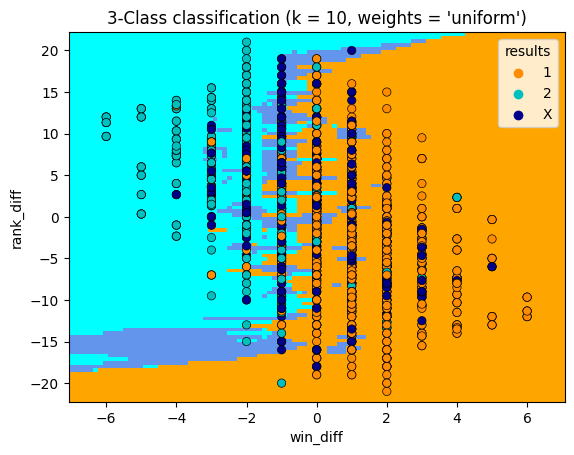

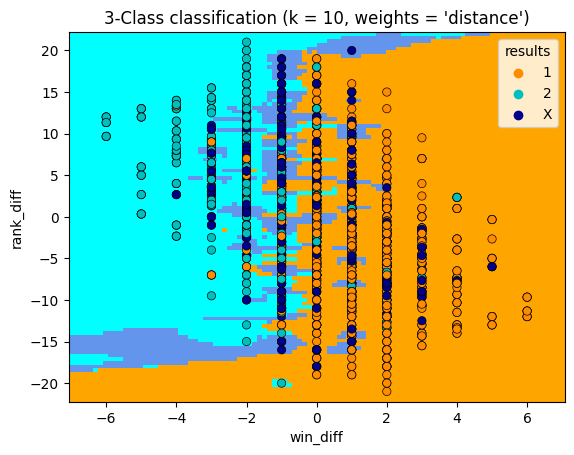

In [96]:
n_neighbors = 15

# we only take the first two features. We could avoid this ugly
# slicing by using a two-dim dataset
col_names = ["win_diff", "rank_diff"]
X = x_train[col_names]
y = x_train.results
x_train_true = X.iloc[:2000,:]
y_train_true = y.iloc[:2000]
x_test_true = X.iloc[2000:,:]
y_test_true = y.iloc[2000:]

# Create color maps
cmap_light = ListedColormap(["orange", "cyan", "cornflowerblue"])
cmap_bold = ["darkorange", "c", "darkblue"]

for weights in ["uniform", "distance"]:
    # we create an instance of Neighbours Classifier and fit the data.
    clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
    clf.fit(x_train_true, y_train_true)

    _, ax = plt.subplots()
    DecisionBoundaryDisplay.from_estimator(
        clf,
        x_train_true,
        cmap=cmap_light,
        ax=ax,
        response_method="predict",
        plot_method="pcolormesh",
        xlabel="win_diff",
        ylabel="rank_diff",
        shading="auto",
    )

    # Plot also the training points
    sns.scatterplot(
        x=x_train_true["win_diff"],
        y=x_train_true["rank_diff"],
        hue=y_train_true,
        palette=cmap_bold,
        alpha=1.0,
        edgecolor="black",
    )
    plt.title(
        "3-Class classification (k = %i, weights = '%s')" % (n_neighbors, weights)
    )

In [97]:
clf.score(x_test_true, y_test_true)

0.55893536121673

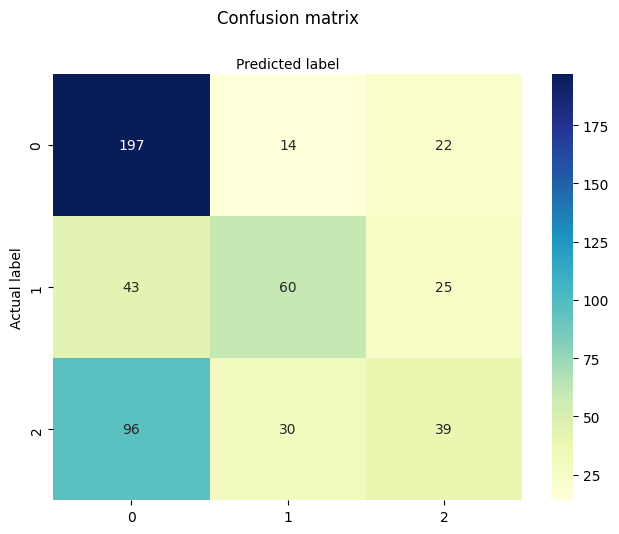

In [87]:
y_pred = clf.predict(x_test_true)

from sklearn import metrics

cnf_matrix = metrics.confusion_matrix(y_test_true, y_pred)
cnf_matrix
import seaborn as sns

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

plt.Text(0.5,257.44,'Predicted label');